Data from [Sequencing metabolically labeled transcripts in single cells reveals mRNA turnover strategies.](https://doi.org/10.1126/science.aax3072)

In [1]:
import numpy as np
from CoPhaser import utils
from CoPhaser.trainer import Trainer
from CoPhaser.loss import Loss
from CoPhaser import plotting
from CoPhaser.model import CoPhaser
from CoPhaser import gene_sets


import matplotlib.pyplot as plt
import seaborn as sns

import anndata
import scanpy as sc
import pickle

import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA_FOLDER = "../../../data/"
adata = anndata.read_h5ad(f"{DATA_FOLDER}battich/Battich_RPE1_labeled.loom")
adata

AnnData object with n_obs × n_vars = 5422 × 11402
    obs: 'Plate_Id', 'Condition_Id', 'Well_Id', 'RFP_log10_corrected', 'GFP_log10_corrected', 'Cell_cycle_possition', 'Cell_cycle_relativePos'
    var: 'Gene_Id', 'Symbol', 'Name'
    layers: 'matrix', 'spliced', 'unspliced'

In [4]:
adata.var_names = adata.var.Symbol

<Axes: xlabel='Cell_cycle_possition', ylabel='Cell_cycle_relativePos'>

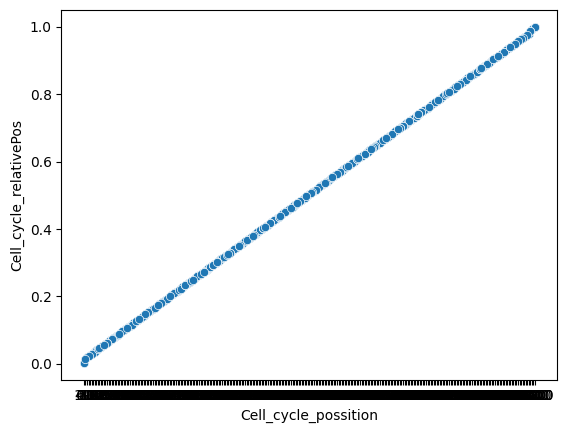

In [5]:
sns.scatterplot(
    x=adata.obs["Cell_cycle_possition"],
    y=adata.obs["Cell_cycle_relativePos"].astype(float),
)

In [52]:
adata.obs

,Plate_Id,Condition_Id,Well_Id,RFP_log10_corrected,GFP_log10_corrected,Cell_cycle_possition,Cell_cycle_relativePos,s_counts,u_counts,percent_unspliced,total_counts,pca_theta,Cell_cycle_position,inferred_theta,library_size
Cell_00002,plate01,Chase_120,9.0,0.8986272417761243,3.16150620502695,101.0,0.3366666666666667,2655,447,0.144101,3102,2.507310,-1.026254,-1.599156,2655
Cell_00004,plate01,Chase_60,14.0,1.097916956420803,2.6539723106228985,89.0,0.2966666666666667,3323,622,0.157668,3945,-2.905383,-1.277581,-1.221271,3323
Cell_00005,plate01,Chase_60,17.0,1.0521083551325905,3.0418897524684665,104.0,0.3466666666666667,6004,1159,0.161804,7163,-2.951920,-0.963422,-1.181634,6004
Cell_00007,plate01,Chase_0,21.0,0.3793781451156013,2.9791875797563594,83.0,0.2766666666666667,2234,578,0.205548,2812,2.806667,-1.403245,-1.768018,2234
Cell_00008,plate01,Chase_dmso,22.0,0.7256503954652888,1.8512558800664656,35.0,0.11666666666666667,1995,473,0.191653,2468,0.722824,-2.408554,-3.108839,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell_05416,plate10,Pulse_45,371.0,2.6787109375000004,3.105224609374999,183.0,0.61,1026,1329,0.564331,2355,-1.871011,0.691150,0.122342,1026
Cell_05418,plate10,Pulse_120,376.0,0.6624145507812502,1.96307373046875,40.0,0.13333333333333333,1542,1110,0.418552,2652,-1.319595,-2.303835,0.492314,1542
Cell_05420,plate10,Pulse_180,379.0,2.4844970703125,3.11181640625,176.0,0.5866666666666666,2591,1476,0.362921,4067,-1.373614,0.544543,0.605866,2591
Cell_05421,plate10,Pulse_180,380.0,0.4707031249999996,3.2412719726562487,91.0,0.3033333333333333,3485,1840,0.345540,5325,-2.881436,-1.235693,-0.860083,3485


In [6]:
adata.layers["spliced"] = adata.layers["spliced"].astype("uint16")
adata.layers["unspliced"] = adata.layers["unspliced"].astype("uint16")

In [7]:
sc.pp.filter_genes(adata, min_cells=10)

In [8]:
# create a new layer copy of the spliced layer
adata.layers["s_norm"] = adata.layers["spliced"].copy()
adata.layers["u_norm"] = adata.layers["unspliced"].copy()

# normalize the spliced layer, adding layer option, indicates which layer we want to normalize
sc.pp.normalize_total(adata, target_sum=1e4, layer="s_norm")
sc.pp.normalize_total(adata, target_sum=1e4, layer="u_norm")

# copy the normalized layer to a new layer, s_log
adata.layers["s_log"] = adata.layers["s_norm"].copy()
adata.layers["u_log"] = adata.layers["u_norm"].copy()

# log transform the normalized layer
sc.pp.log1p(adata, layer="s_log")
sc.pp.log1p(adata, layer="u_log")
# add % unspliced to adata.obs
adata.obs["s_counts"] = adata.layers["spliced"].sum(axis=1)
adata.obs["u_counts"] = adata.layers["unspliced"].sum(axis=1)

adata.obs["percent_unspliced"] = adata.obs["u_counts"] / (
    adata.obs["u_counts"] + adata.obs["s_counts"]
)

/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


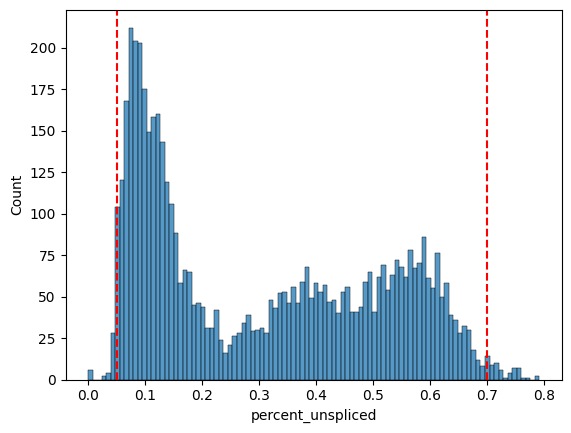

In [9]:
# plot distribution of % unspliced
sns.histplot(adata.obs["percent_unspliced"], bins=100)
# lower threshold for % unspliced
low_percent_unspliced = 0.05
# upper threshold for % unspliced
high_percent_unspliced = 0.7
plt.axvline(low_percent_unspliced, color="red", linestyle="--")
plt.axvline(high_percent_unspliced, color="red", linestyle="--")

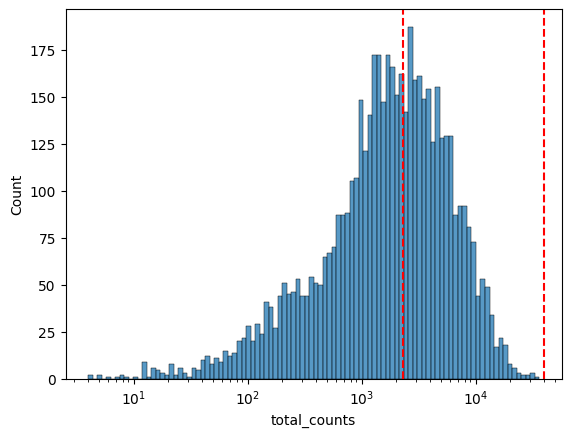

In [10]:
# add total counts to adata.obs
adata.obs["total_counts"] = adata.layers["spliced"].sum(axis=1) + adata.layers[
    "unspliced"
].sum(axis=1)
# plot distribution of total counts
sns.histplot(adata.obs["total_counts"], bins=100, log_scale=True)
# lower threshold for total counts
low_total_counts = 2300
# upper threshold for total counts
high_total_counts = 40000
plt.axvline(low_total_counts, color="red", linestyle="--")
plt.axvline(high_total_counts, color="red", linestyle="--")

In [11]:
# filter cells based on thresholds
adata = adata[
    (adata.obs["percent_unspliced"] > low_percent_unspliced)
    & (adata.obs["percent_unspliced"] < high_percent_unspliced)
    & (adata.obs["total_counts"] > low_total_counts)
    & (adata.obs["total_counts"] < high_total_counts)
].copy()

In [12]:
adata.obs

,Plate_Id,Condition_Id,Well_Id,RFP_log10_corrected,GFP_log10_corrected,Cell_cycle_possition,Cell_cycle_relativePos,s_counts,u_counts,percent_unspliced,total_counts
Cell_00002,plate01,Chase_120,9.0,0.8986272417761243,3.16150620502695,101.0,0.3366666666666667,2655,447,0.144101,3102
Cell_00004,plate01,Chase_60,14.0,1.097916956420803,2.6539723106228985,89.0,0.2966666666666667,3323,622,0.157668,3945
Cell_00005,plate01,Chase_60,17.0,1.0521083551325905,3.0418897524684665,104.0,0.3466666666666667,6004,1159,0.161804,7163
Cell_00007,plate01,Chase_0,21.0,0.3793781451156013,2.9791875797563594,83.0,0.2766666666666667,2234,578,0.205548,2812
Cell_00008,plate01,Chase_dmso,22.0,0.7256503954652888,1.8512558800664656,35.0,0.11666666666666667,1995,473,0.191653,2468
...,...,...,...,...,...,...,...,...,...,...,...
Cell_05416,plate10,Pulse_45,371.0,2.6787109375000004,3.105224609374999,183.0,0.61,1026,1329,0.564331,2355
Cell_05418,plate10,Pulse_120,376.0,0.6624145507812502,1.96307373046875,40.0,0.13333333333333333,1542,1110,0.418552,2652
Cell_05420,plate10,Pulse_180,379.0,2.4844970703125,3.11181640625,176.0,0.5866666666666666,2591,1476,0.362921,4067
Cell_05421,plate10,Pulse_180,380.0,0.4707031249999996,3.2412719726562487,91.0,0.3033333333333333,3485,1840,0.345540,5325


In [13]:
to_save = {}
to_save["cells_indices"] = adata.obs.index.to_numpy()

In [14]:
adata.X = adata.layers["spliced"].copy()  # + adata.layers["unspliced"]

In [15]:
adata

AnnData object with n_obs × n_vars = 2305 × 10508
    obs: 'Plate_Id', 'Condition_Id', 'Well_Id', 'RFP_log10_corrected', 'GFP_log10_corrected', 'Cell_cycle_possition', 'Cell_cycle_relativePos', 's_counts', 'u_counts', 'percent_unspliced', 'total_counts'
    var: 'Gene_Id', 'Symbol', 'Name', 'n_cells'
    uns: 'log1p'
    layers: 'matrix', 'spliced', 'unspliced', 's_norm', 'u_norm', 's_log', 'u_log'

In [16]:
adata_all_genes = adata.copy()
layer_to_use = "spliced"
library_size = adata_all_genes.layers[layer_to_use].sum(axis=1)

In [17]:
# Preprocess data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [18]:
adata.var_names

Index(['TSPAN6', 'DPM1', 'SCYL3', 'C1orf112', 'CFH', 'FUCA2', 'GCLC', 'NFYA',
       'STPG1', 'NIPAL3',
       ...
       'GGNBP2', 'DHRS11', 'ACACA', 'BACE1-AS', 'MRPL45', 'HEIH', 'HELLPAR',
       'EBLN3P', 'FRG1CP', 'PTMAP12'],
      dtype='object', name='Symbol', length=10508)

In [19]:
SMALL_CYCLING_GENE_SET = gene_sets.SMALL_CELL_CYCLE_GENE_SET
SMALL_CYCLING_GENE_SET = [x.upper() for x in SMALL_CYCLING_GENE_SET]
adata = adata[:, adata.var_names.isin(SMALL_CYCLING_GENE_SET)]

In [20]:
adata

View of AnnData object with n_obs × n_vars = 2305 × 95
    obs: 'Plate_Id', 'Condition_Id', 'Well_Id', 'RFP_log10_corrected', 'GFP_log10_corrected', 'Cell_cycle_possition', 'Cell_cycle_relativePos', 's_counts', 'u_counts', 'percent_unspliced', 'total_counts'
    var: 'Gene_Id', 'Symbol', 'Name', 'n_cells'
    uns: 'log1p'
    layers: 'matrix', 'spliced', 'unspliced', 's_norm', 'u_norm', 's_log', 'u_log'

In [21]:
adata

View of AnnData object with n_obs × n_vars = 2305 × 95
    obs: 'Plate_Id', 'Condition_Id', 'Well_Id', 'RFP_log10_corrected', 'GFP_log10_corrected', 'Cell_cycle_possition', 'Cell_cycle_relativePos', 's_counts', 'u_counts', 'percent_unspliced', 'total_counts'
    var: 'Gene_Id', 'Symbol', 'Name', 'n_cells'
    uns: 'log1p'
    layers: 'matrix', 'spliced', 'unspliced', 's_norm', 'u_norm', 's_log', 'u_log'

In [22]:
# mean center the adata
adata.X = adata.X - adata.X.mean(axis=1).reshape(-1, 1)

/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/site-packages/anndata/_core/anndata.py:636: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/tmp/ipykernel_370022/1519362621.py:2: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata.X = adata.X - adata.X.mean(axis=1).reshape(-1, 1)


/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:384: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = x_pca


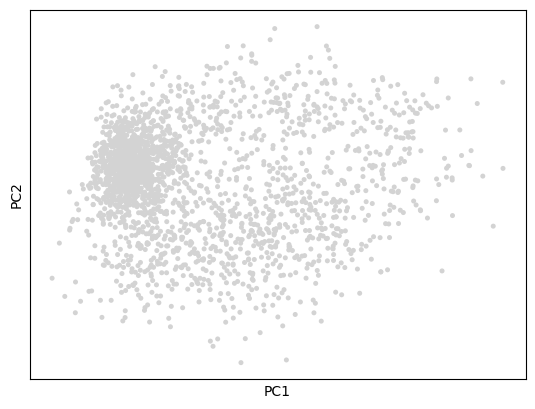

In [24]:
# pca on the data
sc.pp.pca(adata, n_comps=10)
# plot the pca
sc.pl.pca(adata)

In [25]:
# add PCA theta to adata.obs
adata.obs["pca_theta"] = np.arctan2(
    adata.obsm["X_pca"][:, 1], adata.obsm["X_pca"][:, 0]
)
adata_all_genes.obs["pca_theta"] = adata.obs["pca_theta"].copy()
adata = adata_all_genes.copy()

In [26]:
adata.layers["total"] = adata.layers["spliced"] + adata.layers["unspliced"]

<Axes: ylabel='Frequency'>

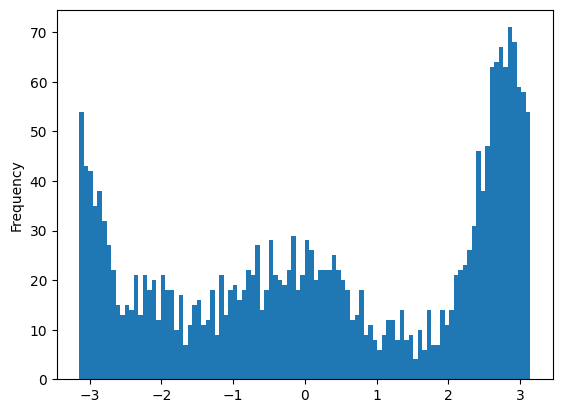

In [27]:
adata.obs["pca_theta"].plot.hist(bins=100)

In [28]:
g = utils.get_variable_genes(adata)
len(g)

2000

In [29]:
SMALL_CYCLING_GENE_SET = [g for g in SMALL_CYCLING_GENE_SET if g in adata.var_names]

In [30]:
adata.obs["Cell_cycle_position"] = (
    adata.obs["Cell_cycle_possition"].astype(float) / 300 * 2 * np.pi - np.pi
)

<Axes: >

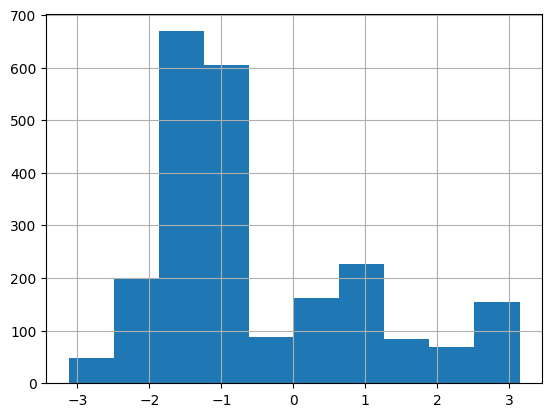

In [31]:
adata.obs["Cell_cycle_position"].hist()

Epoch 1/200, elbo_loss: 787.4659, kl_div_f: 4.6789, kl_div_z: 8.6019, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.0029, entropy_loss: -60.0589, radial_variance: 2.7286, radius: 3.5935, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 733.7291
Epoch 2/200, elbo_loss: 679.2888, kl_div_f: 4.6276, kl_div_z: 7.6426, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.2727, entropy_loss: -65.4549, radial_variance: 1.4723, radius: 2.8328, L1_mu_z: 0.0000, MI_loss: -0.0000, total_loss: 618.1383
Epoch 3/200, elbo_loss: 662.1538, kl_div_f: 4.5666, kl_div_z: 8.2125, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.2764, entropy_loss: -65.5283, radial_variance: 1.3175, radius: 2.2506, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 600.1977
Epoch 4/200, elbo_loss: 650.4793, kl_div_f: 4.5022, kl_div_z: 8.2128, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.2715, entropy_loss: -

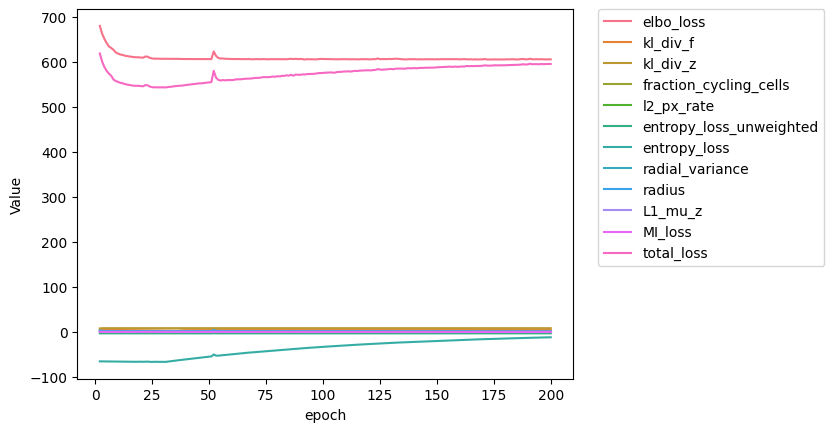

In [38]:
model = CoPhaser(
    SMALL_CYCLING_GENE_SET,
    g,
    n_latent=2,
)
model.load_anndata(adata, layer_to_use="spliced")
trainer = Trainer(
    model,
    Loss.compute_loss,
    noise_model="NB",
    non_rhythmic_likelihood_weight=0.5,
    rhythmic_likelihood_weight=2,
    L2_Z_decoder_loss_weight=0,
    closed_circle_weight=10,
    cycling_status_prior=1,
    MI_weight=100,
    entropy_weight_factor=20,
    MI_detach="f",
)
trainer.train_model(
    n_epochs=200,
    lr=1e-2,
    device="cuda",
    batch_size=128,
)

<Axes: ylabel='Count'>

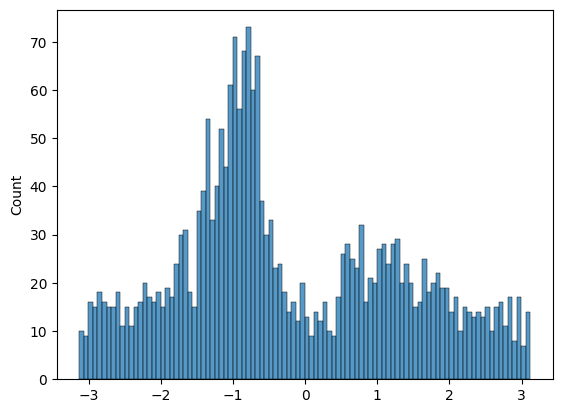

In [39]:
# Get the infered theta values
model.to("cpu")
generative_outputs, space_outputs = model.get_outputs()
thetas = space_outputs["theta"].detach().numpy()
sns.histplot(thetas, bins=100)

<Axes: >

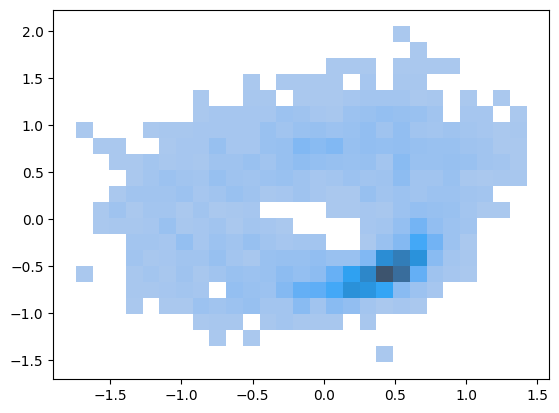

In [40]:
cells_projected = space_outputs["x_projected"].detach().numpy()
sns.histplot(x=cells_projected[:, 0], y=cells_projected[:, 1])

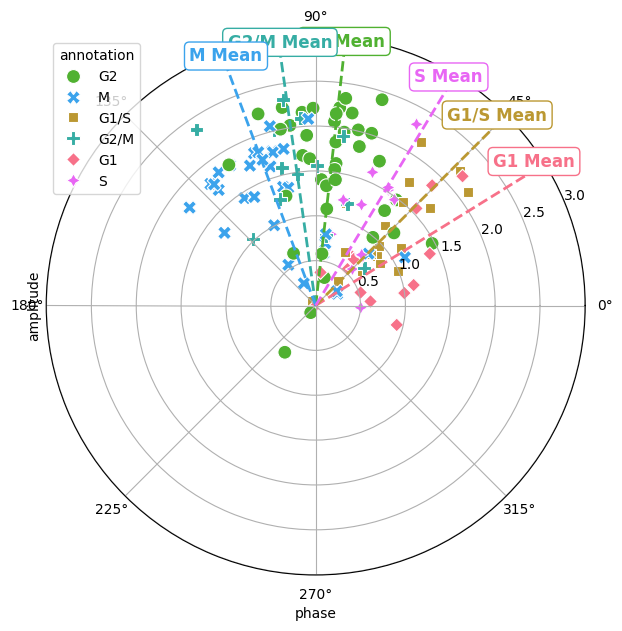

In [41]:
thetas = model.infer_pseudotimes(adata, "spliced", True)
adata.obs["inferred_theta"] = thetas

In [42]:
def add_theta(df, theta, theta_pca, theta_fucci):
    df["inferred_theta"] = theta
    df["pca_theta"] = theta_pca
    df["theta_fucci"] = theta_fucci
    return df


df_mean = pd.DataFrame(
    generative_outputs["px_rate"].detach().numpy(), columns=model.context_genes
)
df_mean = add_theta(
    df_mean,
    thetas,
    adata.obs["pca_theta"].values,
    adata.obs["Cell_cycle_position"].astype(float).values,
)
# df_rhythmic = pd.DataFrame(generative_outputs["rhythmic_term"].detach().numpy(), columns=model.rhythmic_gene_names)
df_rhythmic = pd.DataFrame(
    generative_outputs["F"].detach().numpy(), columns=model.context_genes
)
df_rhythmic = add_theta(
    df_rhythmic,
    thetas,
    adata.obs["pca_theta"].values,
    adata.obs["Cell_cycle_position"].astype(float).values,
)
df_z = pd.DataFrame(
    generative_outputs["Z"].detach().numpy(), columns=model.context_genes
)
df_z = add_theta(
    df_z,
    thetas,
    adata.obs["pca_theta"].values,
    adata.obs["Cell_cycle_position"].astype(float).values,
)

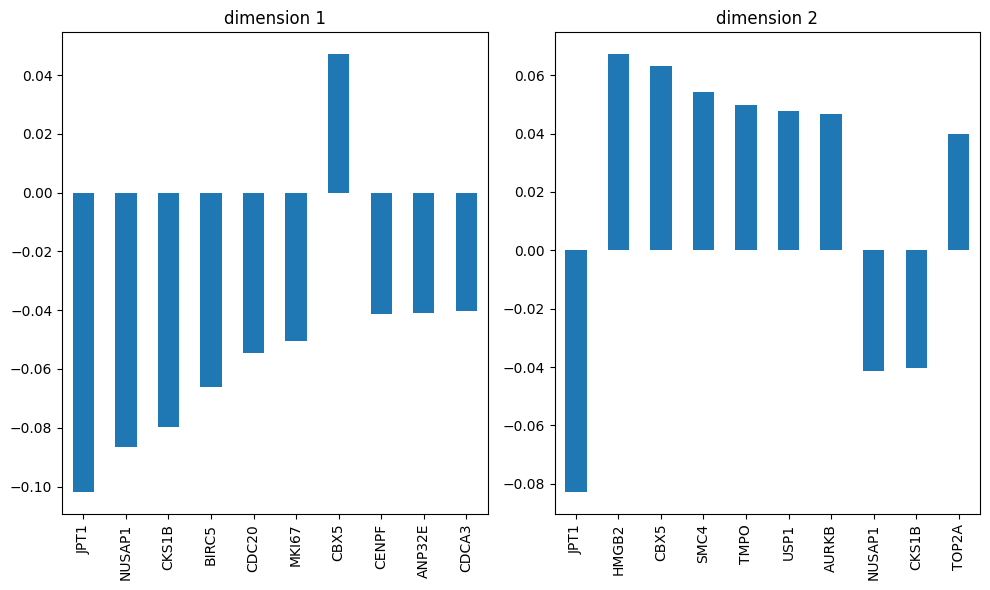

In [43]:
from CoPhaser.model import interpretability

attributions = interpretability.compute_avg_feature_attributions(model, 128)
plotting.plot_feature_importance(attributions, model.rhythmic_gene_names)

<Axes: >

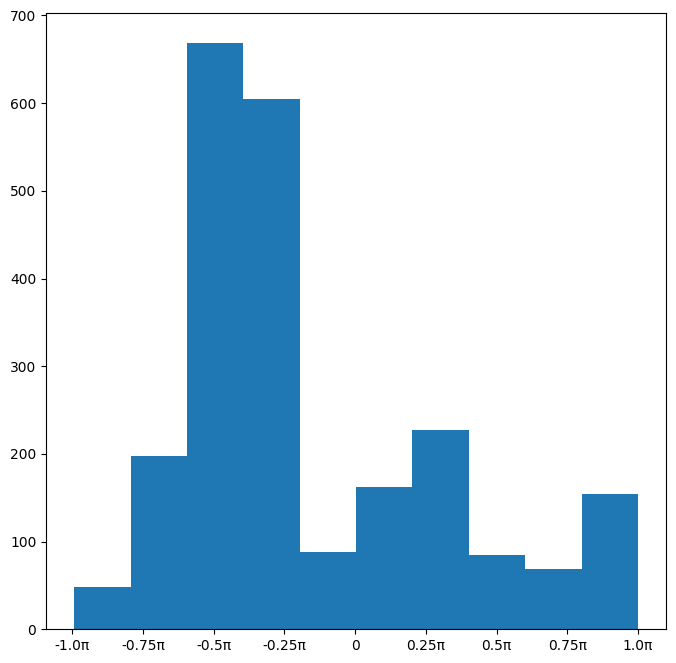

In [44]:
fig, ax = plotting.modify_axis_labels(axis="x")
df_mean["theta_fucci"].hist(grid=False)

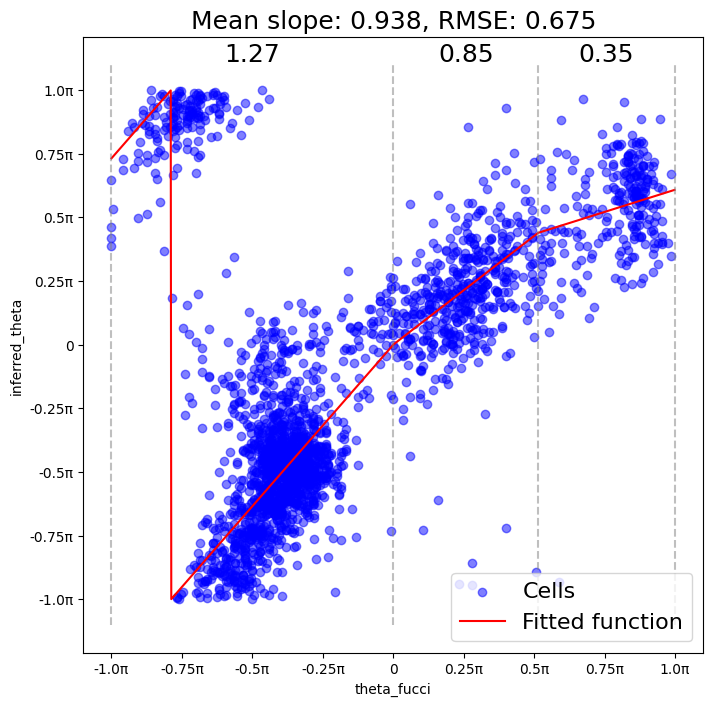


Optimized breakpoints:
Breakpoint 0: -3.142 rad = -180.0°
Breakpoint 1: 0.002 rad = 0.1°
Breakpoint 2: 1.614 rad = 92.5°
Breakpoint 3: 3.142 rad = 180.0°
RMSE: 0.675
Mean slope: 0.938


In [45]:
plt.rcParams.update({"axes.titlesize": 18})
plt.rcParams.update({"legend.fontsize": 16})
plotting.modify_axis_labels(axis="both")
utils.fit_piecewise_linear(
    df_mean, xlabel="theta_fucci", ylabel="inferred_theta", n_pieces=3
)

/home/maxine/Documents/paychere/CoPhaser/src/CoPhaser/plotting.py:548: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend(loc="upper left", bbox_to_anchor=(1, 1))


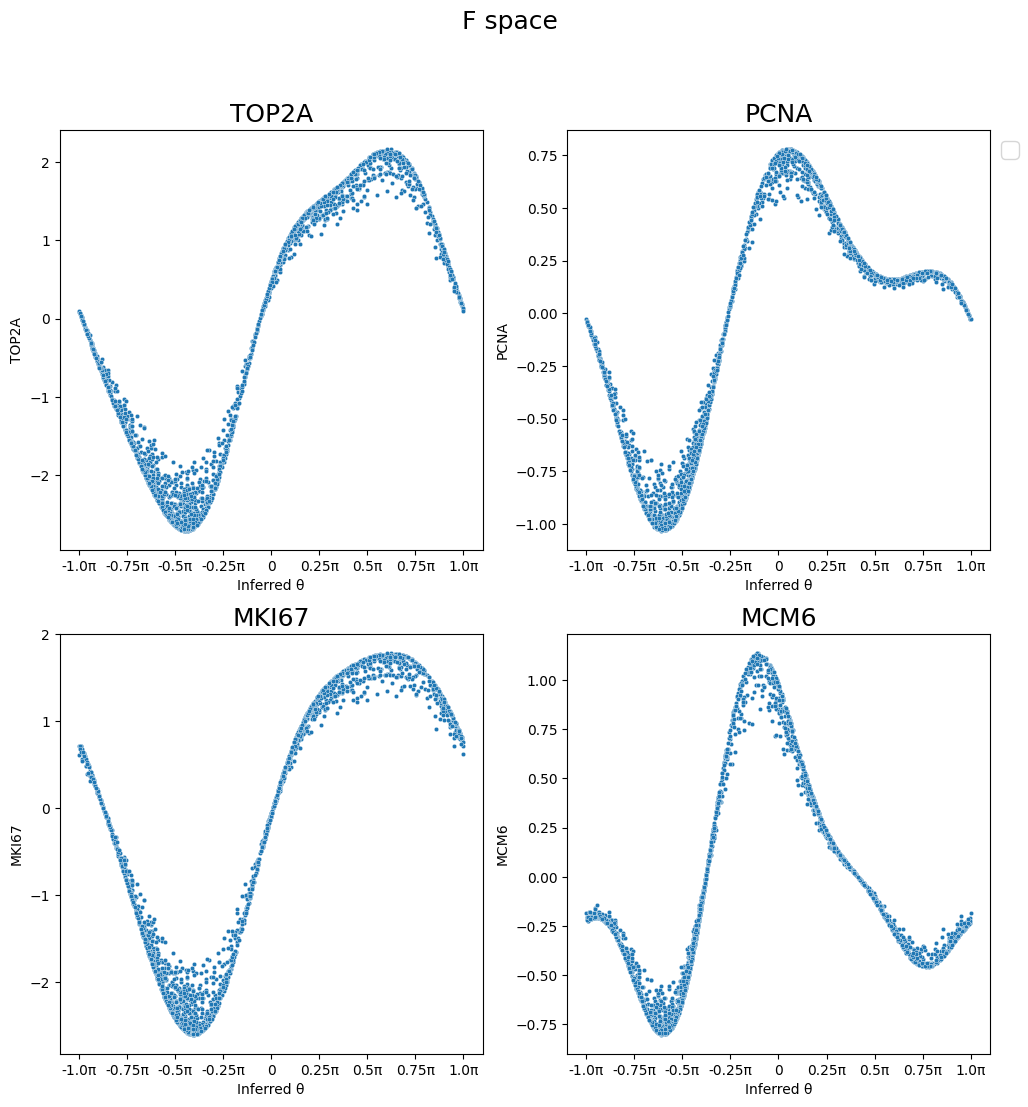

In [46]:
plotting.plot_model_decoded_space(df_rhythmic, gene_to_upper=True, title="F space")

In [47]:
library_size = adata.layers["spliced"].sum(axis=1)

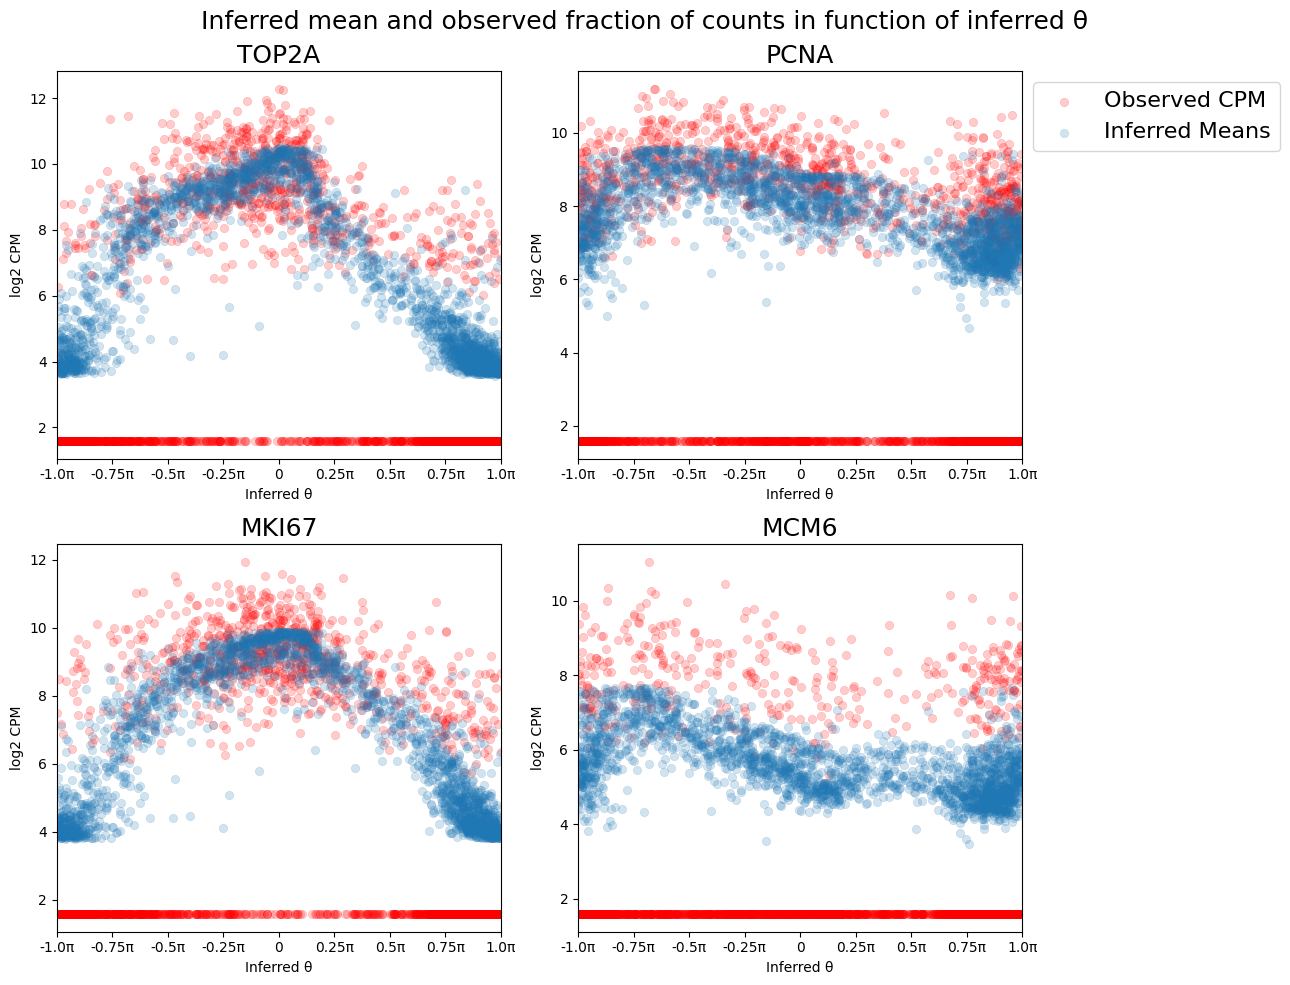

In [48]:
plotting.plot_gene_profile(
    df_mean,
    adata,
    layer_to_use="spliced",
    library_size=library_size,
    theta_col="pca_theta",
)

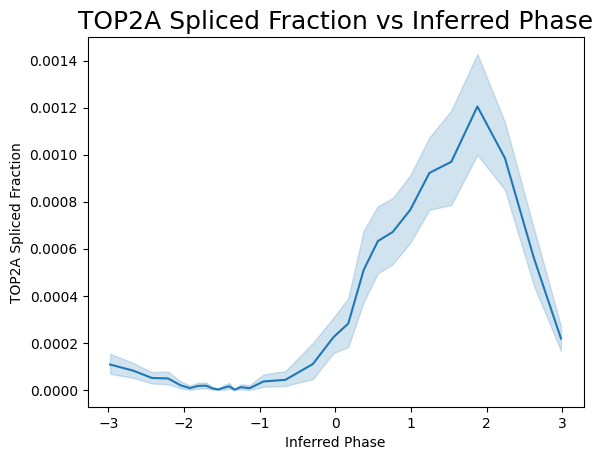

In [49]:
top2a_fractions = adata[:, "TOP2A"].layers["spliced"].toarray().flatten() / library_size


def plot_smoothed_profiles(
    x, y, ax, hue=None, nbins=20, xlabel=None, ylabel=None, title=None
):
    x = [val.mid for val in pd.qcut(x, q=nbins)]
    sns.lineplot(x=x, y=y, hue=hue, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)


plot_smoothed_profiles(
    thetas.detach().numpy(),
    top2a_fractions,
    ax=plt.gca(),
    nbins=30,
    xlabel="Inferred Phase",
    ylabel="TOP2A Spliced Fraction",
    title="TOP2A Spliced Fraction vs Inferred Phase",
)

In [50]:
adata.obs["library_size"] = library_size
adata.obs["inferred_theta"] = df_mean["inferred_theta"].to_numpy()

In [51]:
to_save["df_rhythmic"] = df_rhythmic
to_save["df_mean"] = df_mean
to_save["z"] = {
    "z1": space_outputs["z"][:, 0].detach().numpy(),
    "z2": space_outputs["z"][:, 1].detach().numpy(),
}
# pickle.dump(to_save, open("data/battich_results.pkl", "wb"))